
# Projet Data Management – Collections des musées de France (Joconde)

Ce notebook regroupe l'ensemble du travail réalisé pour le projet :  
- présentation et préparation du jeu de données Joconde  
- nettoyage et création de variables  
- analyses descriptives (temps, domaines, géographie, etc.)  
- text mining sur un article lié à la politique d’acquisition publique d’œuvres d’art  



##  Exploration, nettoyage et analyse du jeu de données Joconde

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [3]:
# Cellule 1 : chargement

df_raw = pd.read_csv("base-joconde-extrait.csv", sep=";", encoding="utf-8", low_memory=False)
df = df_raw.copy()   # dataframe de travail
df.head()


,Reference,Ancien_depot,Appellation,Ancienne_appartenance,Ancienne_attribution,Auteur,Bibliographie,Commentaires,Presence_image,Date_d_acquisition,...,Lien_INHA,Source_de_la_representation,Statut_juridique,Materiaux_techniques,Titre,Utilisation,Lien_site_associe,coordonnees,Artiste_sous_droits,Date_entree_dans_le_domaine_public
0,09880004556,NaN,NaN,NaN,NaN,NaN,"RETHORE Pascale, 1988, rapport de fouille",NaN,non,NaN,...,NaN,NaN,propriété publique,terre cuite,NaN,NaN,NaN,"44.931125, 4.889563",NaN,NaN
1,50010013000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,non,NaN,...,NaN,NaN,EARM,silex,NaN,NaN,NaN,"48.897879, 2.094936",NaN,NaN
2,50010013094,NaN,NaN,Chauvet Stephen,NaN,NaN,NaN,NaN,non,1883,...,NaN,NaN,propriété de l'Etat;don manuel;Saint-Germain-e...,silex,NaN,NaN,NaN,"48.897879, 2.094936",NaN,NaN
3,50010001934,NaN,NaN,Piroutet,NaN,NaN,NaN,NaN,non,1913,...,NaN,NaN,propriété de l'Etat;achat;Saint-Germain-en-Lay...,bronze,NaN,bijou,NaN,"48.897879, 2.094936",NaN,NaN
4,04350001573,NaN,NaN,Centre de recherches archéologiques du Vexin f...,NaN,NaN,NaN,Pas d'objets associés dans la sépulture.; Inco...,non,1991 entrée matérielle,...,NaN,NaN,propriété du département;Val d'Oise;musée arch...,Bronze,NaN,médecine;toilette,NaN,"49.108589, 1.849395",NaN,NaN


In [4]:
# Comptage des valeurs vides par colonne (NaN + chaînes vides/espaces)


n = len(df_raw)

# 1) Valeurs manquantes (NaN)
na_counts = df_raw.isna().sum()

# 2) Chaînes vides / espaces (uniquement colonnes texte)
text_cols = df_raw.select_dtypes(include=["object", "string"]).columns
empty_counts = pd.Series(0, index=df_raw.columns)
if len(text_cols) > 0:
    empty_counts[text_cols] = df_raw[text_cols].apply(
        lambda s: s.astype(str).str.strip().eq("").sum()
    )

# Total vides
total_missing = (na_counts + empty_counts).astype(int)
pct_missing = (total_missing / n * 100).round(2)

# Tableau résultat (trié)
vides_par_colonne = (
    pd.DataFrame({
        "colonne": total_missing.index,
        "valeurs_vides": total_missing.values,
        "pourcentage": pct_missing.values
    })
    .sort_values("valeurs_vides", ascending=False)
    .reset_index(drop=True)
)

vides_par_colonne


,colonne,valeurs_vides,pourcentage
0,References_Merimee,721627,100.00
1,References_Memoires,721601,100.00
2,References_Palissy,721593,100.00
3,Lien_Video,721380,99.97
4,Manquant commentaires,720467,99.84
...,...,...,...
62,Code_Museofile,0,0.00
63,Numero_inventaire,0,0.00
64,Domaine,0,0.00
65,Presence_image,0,0.00


In [4]:
# inspection des colonnes
for col in df.columns:
    print(col)


Reference
Ancien_depot
Appellation
Ancienne_appartenance
Ancienne_attribution
Auteur
Bibliographie
Commentaires
Presence_image
Date_d_acquisition
Date_de_depot
Decouverte_collecte
Denomination
Lieu_de_depot
Description
Mesures
Date_de_mise_a_jour
Date_creation
Domaine
Region
Departement
Date_sujet_represente
Ecole_pays
Epoque
Exposition
Genese
Geographie_historique
Inscription
Numero_inventaire
Appellation_Musee_de_France
Lien_base_Arcade
Lieu_de_creation_utilisation
Localisation
Ville
Lien_Video
Manquant
Manquant commentaires
Millesime_de_creation
Millesime_d_utilisation
Code_Museofile
Nom_officiel_musee
Genre
Onomastique
Precisions_sur_l_auteur
Precisions_decouverte_collecte
Periode_de_l_original_copie
Periode_de_creation
Periode_d_utilisation
Precisions_inscriptions
Precisions_lieux_creations
Precisions_sujets_representes
Precisions_utilisation
References_Memoires
References_Merimee
Reference_MAJ
References_Palissy
Sujet_Represente
Lien_INHA
Source_de_la_representation
Statut_juridi

In [5]:
#  après le chargement et l’inspection des colonnes
df_clean = df.copy()

colonnes_a_supprimer = [
    'ï»¿Reference', 'Ancien_depot', 'Ancienne_appartenance', 'Ancienne_attribution',
    'Bibliographie', 'Commentaires', 'Presence_image', 'Date_de_depot', 'Reference' ,
    'Decouverte_collecte', 'Lieu_de_depot', 'Description', 'Date_de_mise_a_jour',
    'Departement', 'Exposition', 'Lien_site_associe', 'coordonnees', 'Genese',
    'Geographie_historique', 'Inscription', 'Numero_inventaire', 'Mesures' , 
    'Appellation_Musee_de_France', 'Lien_base_Arcade', 'Lieu_de_creation_utilisation',
    'Localisation', 'Lien_Video', 'Manquant', 'Manquant commentaires',
    'Millesime_de_creation', 'Millesime_d_utilisation', 'Code_Museofile', 'Onomastique',
    'Precisions_sur_l_auteur', 'Precisions_decouverte_collecte',
    'Periode_de_l_original_copie', 'Periode_de_creation', 'Periode_d_utilisation', 'Date_sujet_represente' ,
    'Precisions_inscriptions', 'Precisions_lieux_creations',
    'Precisions_sujets_representes', 'Precisions_utilisation',
    'References_Memoires', 'References_Merimee', 'Reference_MAJ', 'References_Palissy',
    'Sujet_Represente', 'Lien_INHA', 'Source_de_la_representation', 'Statut_juridique',
    'Materiaux_techniques', 'Utilisation', 'Artiste_sous_droits',
    'Date_entree_dans_le_domaine_public', 'Denomination'
]

df_clean = df_clean.drop(columns=colonnes_a_supprimer, errors='ignore')


In [6]:
domaines_utiles = [
    "art contemporain", "dessin", "beaux-arts", "vitrail", "arts décoratifs",
    "photographie", "artisanat - industrie", "architecture", "imprimé",
    "égyptien", "cartes - plans", "estampe", "peinture"
]

def garder_domaine(val):
    if not isinstance(val, str):
        return False
    val = val.lower()
    for d in domaines_utiles:
        if d in val:  # on garde si au moins un domaine utile apparaît dans le texte
            return True
    return False

df_clean = df_clean[df_clean["Domaine"].apply(garder_domaine)]

df_clean.head(5)


,Appellation,Auteur,Date_d_acquisition,Date_creation,Domaine,Region,Ecole_pays,Epoque,Ville,Nom_officiel_musee,Genre,Titre
109,NaN,NaN,NaN,NaN,"archéologie,égyptien",Hauts-de-France,NaN,Nouvel empire,Lille,musée des Beaux-Arts,NaN,NaN
110,NaN,NaN,date d'acquisition inconnue,NaN,"archéologie,architecture",Hauts-de-France,NaN,NaN,Lille,musée des Beaux-Arts,NaN,NaN
118,NaN,NaN,NaN,NaN,"archéologie,égyptien",Hauts-de-France,NaN,NaN,Lille,musée des Beaux-Arts,NaN,Taureau sacré (sans doute Apis)
131,NaN,NaN,date d'acquisition inconnue,NaN,"archéologie,égyptien",Hauts-de-France,NaN,NaN,Lille,musée des Beaux-Arts,NaN,NaN
132,NaN,NaN,NaN,NaN,"archéologie,égyptien,sculpture",Hauts-de-France,NaN,NaN,Lille,musée des Beaux-Arts,NaN,Pharaon


In [8]:
# Années de création et d'acquisition
df_clean["Annee_creation"] = pd.to_datetime(
    df_clean["Date_creation"], errors="coerce", dayfirst=True
).dt.year

df_clean["Annee_acquisition"] = pd.to_datetime(
    df_clean["Date_d_acquisition"], errors="coerce", dayfirst=True
).dt.year


/var/folders/sb/l32lpbzn0l53j2_x5fn4htw80000gp/T/ipykernel_17977/2237201187.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_clean["Annee_acquisition"] = pd.to_datetime(


In [9]:
# Comptage des acquisitions par année 
acquisitions_par_annee = (
    df_clean["Annee_acquisition"]
    .value_counts(dropna=True)  # par défaut, dropna=True
    .sort_index()               # pour avoir les années dans l'ordre
)

print(acquisitions_par_annee)


Annee_acquisition
1682.0       1
1683.0       1
1685.0       1
1690.0    3064
1694.0       4
          ... 
2024.0     295
2025.0      16
2066.0       2
2081.0       2
2082.0       1
Name: count, Length: 268, dtype: int64


In [ ]:
# On remarque plusieurs incohérences : la première acquision remonte à 1682 
# presque un siècle avant la création du 1er musée en france (Louvre, Révolution) 
# probablement des erreurs de saisie, confusion entre date de création de l'oeuvre et sa date d'acquisition
# Ou bien des oeuvres héritées des collections royales
# la dernière aquisition est en 2082 (clairement dans le futur)
# probablement une erreur de saisie ou bien une oeuvre marquée avec une date d'acquisition fausse
# puisqu'on a généré une plage de dates automatique avec le code 
# si une seule œuvre est marquée comme acquise en 2081 ou 2082 (même par erreur), le code va renvoyer 2082

In [10]:
# Décennie d'acquisition 
df_clean["Decennie_acquisition"] = (df_clean["Annee_acquisition"] // 10) * 10


# On enlève seulement les NaN pour calculer min / max
decennes = df_clean["Decennie_acquisition"].dropna()

toutes_les_decennies = pd.Series(
    range(
        int(decennes.min()),          # première décennie
        int(decennes.max()) + 10,     # dernière +10 pour l'inclure
        10                            # pas de 10 ans
    )
)

# Comptage des œuvres par décennie réellement présente
acquisitions_par_decennie = (
    df_clean["Decennie_acquisition"]
    .value_counts(dropna=True)  # les NaN ne sont pas comptés
    .sort_index()
)

# On ajoute les décennies manquantes, avec NaN si aucune œuvre
acquisitions_par_decennie = acquisitions_par_decennie.reindex(
    toutes_les_decennies,
    fill_value=np.nan
)

print(acquisitions_par_decennie)


1680        3.0
1690     3422.0
1700        NaN
1710       34.0
1720        NaN
1730        NaN
1740        4.0
1750       25.0
1760        3.0
1770      249.0
1780       13.0
1790     6362.0
1800     1491.0
1810     3735.0
1820     1564.0
1830     2679.0
1840     2386.0
1850     2884.0
1860    11963.0
1870     5284.0
1880     3965.0
1890    13113.0
1900     6288.0
1910    16976.0
1920    31645.0
1930    30080.0
1940     5926.0
1950    12914.0
1960    14341.0
1970    28550.0
1980    28971.0
1990    30838.0
2000    22040.0
2010    25318.0
2020     6269.0
2030        NaN
2040        NaN
2050        NaN
2060        2.0
2070        NaN
2080        3.0
Name: count, dtype: float64


In [50]:
# incohérences confirmées lorsqu'on survole le nombre d'oeuvres acquises par décennie
# Les decennies anterieures à la création du Louvre ou celles du futur présentent des valeurs trop petites ou absentes 


In [11]:
# On garde uniquement les acquisitions entre 1793 et 2025
df_clean = df_clean[
    (df_clean["Annee_acquisition"] >= 1793) &
    (df_clean["Annee_acquisition"] <= 2025)
]


In [12]:
#verification
print("Année min :", df_clean["Annee_acquisition"].min())
print("Année max :", df_clean["Annee_acquisition"].max())


Année min : 1793.0
Année max : 2025.0


In [13]:
# Sur le dataframe filtré, on ajoute deux colonnes

acquisitions_par_annee = df_clean["Annee_acquisition"].value_counts().sort_index()

df_clean["Decennie_acquisition"] = (df_clean["Annee_acquisition"] // 10) * 10

acquisitions_par_decennie = df_clean["Decennie_acquisition"].value_counts().sort_index()

df_clean.head()


,Appellation,Auteur,Date_d_acquisition,Date_creation,Domaine,Region,Ecole_pays,Epoque,Ville,Nom_officiel_musee,Genre,Titre,Annee_creation,Annee_acquisition,Decennie_acquisition
380,NaN,NaN,1949,2002-03-07,"archéologie,médiéval,architecture,sculpture",Bretagne,NaN,NaN,Rennes,musée de Bretagne,NaN,NaN,2002.0,1949.0,1940.0
381,NaN,NaN,1949,2002-03-07,"archéologie,médiéval,architecture,sculpture",Bretagne,NaN,NaN,Rennes,musée de Bretagne,NaN,NaN,2002.0,1949.0,1940.0
382,NaN,RAME Alfred,1985,2002-03-07,"archéologie,estampe",Bretagne,NaN,NaN,Rennes,musée de Bretagne,NaN,pierre tombale mérovingienne,2002.0,1985.0,1980.0
386,NaN,NaN,1949,2002-03-07,"archéologie,médiéval,architecture,sculpture",Bretagne,NaN,NaN,Rennes,musée de Bretagne,NaN,NaN,2002.0,1949.0,1940.0
390,NaN,NaN,1949,2002-03-07,"archéologie,médiéval,architecture,sculpture",Bretagne,NaN,moyen âge,Rennes,musée de Bretagne,NaN,NaN,2002.0,1949.0,1940.0


In [ ]:
# date d'acquisition antérieure à la date de création ---> Incohérence 

In [14]:
incoherents = df_clean[
    (df_clean["Annee_creation"].notna()) &
    (df_clean["Annee_acquisition"].notna()) &
    (df_clean["Annee_acquisition"] < df_clean["Annee_creation"])
]

incoherents[["Titre", "Date_creation", "Annee_creation", "Date_d_acquisition", "Annee_acquisition"]].head(10)



,Titre,Date_creation,Annee_creation,Date_d_acquisition,Annee_acquisition
380,NaN,2002-03-07,2002.0,1949,1949.0
381,NaN,2002-03-07,2002.0,1949,1949.0
382,pierre tombale mérovingienne,2002-03-07,2002.0,1985,1985.0
386,NaN,2002-03-07,2002.0,1949,1949.0
390,NaN,2002-03-07,2002.0,1949,1949.0
398,NaN,2002-03-07,2002.0,1856,1856.0
400,NaN,2002-03-07,2002.0,1949,1949.0
403,NaN,2002-03-07,2002.0,1949,1949.0
405,NaN,2002-03-07,2002.0,1949,1949.0
412,NaN,2002-03-07,2002.0,1857,1857.0


In [ ]:
#année de créaton renvoie probablement à l'année de la creation du fichier de l'oeuvre dans la base de données 
# et non à la date de la création l'oeuvre 

In [15]:
df_clean = df_clean.drop(columns=["Date_creation"])
df_clean.head()


,Appellation,Auteur,Date_d_acquisition,Domaine,Region,Ecole_pays,Epoque,Ville,Nom_officiel_musee,Genre,Titre,Annee_creation,Annee_acquisition,Decennie_acquisition
380,NaN,NaN,1949,"archéologie,médiéval,architecture,sculpture",Bretagne,NaN,NaN,Rennes,musée de Bretagne,NaN,NaN,2002.0,1949.0,1940.0
381,NaN,NaN,1949,"archéologie,médiéval,architecture,sculpture",Bretagne,NaN,NaN,Rennes,musée de Bretagne,NaN,NaN,2002.0,1949.0,1940.0
382,NaN,RAME Alfred,1985,"archéologie,estampe",Bretagne,NaN,NaN,Rennes,musée de Bretagne,NaN,pierre tombale mérovingienne,2002.0,1985.0,1980.0
386,NaN,NaN,1949,"archéologie,médiéval,architecture,sculpture",Bretagne,NaN,NaN,Rennes,musée de Bretagne,NaN,NaN,2002.0,1949.0,1940.0
390,NaN,NaN,1949,"archéologie,médiéval,architecture,sculpture",Bretagne,NaN,moyen âge,Rennes,musée de Bretagne,NaN,NaN,2002.0,1949.0,1940.0


In [16]:
# Créer la plage de toutes les années possibles (1793 à 2025)
toutes_les_annees = pd.Series(range(1793, 2026))

# Recompter les acquisitions par année 
acquisitions_par_annee = df_clean["Annee_acquisition"].value_counts().sort_index()

# Réindexer pour inclure les années manquantes avec NaN
acquisitions_par_annee = acquisitions_par_annee.reindex(toutes_les_annees, fill_value=np.nan)

# Affichage
print(acquisitions_par_annee)

1793    3279
1794     275
1795     101
1796    1285
1797      16
        ... 
2021    1462
2022    2435
2023     388
2024     295
2025      16
Name: count, Length: 233, dtype: int64


In [17]:
# Vérification : afficher les années où il n'y a pas eu d'acquisition (NaN)
print(acquisitions_par_annee[acquisitions_par_annee.isna()])

Series([], Name: count, dtype: int64)


In [56]:
# absence de valeurs vides (plutôt encourageant)

In [18]:
# recalculer la colonne décennie sur le dataframe filtré
df_clean["Decennie_acquisition"] = (df_clean["Annee_acquisition"] // 10) * 10

# Créer la plage de toutes les décennies possibles entre 1790 et 2030
toutes_les_decennies = pd.Series(range(1790, 2031, 10))  

# Recompter les acquisitions par décennie 
acquisitions_par_decennie = df_clean["Decennie_acquisition"].value_counts().sort_index()

# Réindexer pour inclure les décennies manquantes avec NaN
acquisitions_par_decennie = acquisitions_par_decennie.reindex(toutes_les_decennies, fill_value=np.nan)

# Affichage
print(acquisitions_par_decennie)


1790     5183.0
1800     1491.0
1810     3735.0
1820     1564.0
1830     2679.0
1840     2386.0
1850     2884.0
1860    11963.0
1870     5284.0
1880     3965.0
1890    13113.0
1900     6288.0
1910    16976.0
1920    31645.0
1930    30080.0
1940     5926.0
1950    12914.0
1960    14341.0
1970    28550.0
1980    28971.0
1990    30838.0
2000    22040.0
2010    25318.0
2020     6269.0
2030        NaN
Name: count, dtype: float64


In [19]:
# Filtrer à nouveau le années et decennies pour plus de précision XIXe --> XXIe (1800 à 2025)

# Années 1800–2025
acquisitions_par_annee_filtrées = acquisitions_par_annee[
    (acquisitions_par_annee.index >= 1800) &
    (acquisitions_par_annee.index <= 2025)
]

# Décennies 1800–2020
acquisitions_par_decennie_filtrées = acquisitions_par_decennie[
    (acquisitions_par_decennie.index >= 1800) &
    (acquisitions_par_decennie.index <= 2020)
]
#Vérification
print(acquisitions_par_annee_filtrées.index.min(), acquisitions_par_annee_filtrées.index.max())
print(acquisitions_par_decennie_filtrées.index.min(), acquisitions_par_decennie_filtrées.index.max())


1800 2025
1800 2020


# APPRECIATION DE LA REPARTITION TEMPORELLE DES ACQUISITIONS 

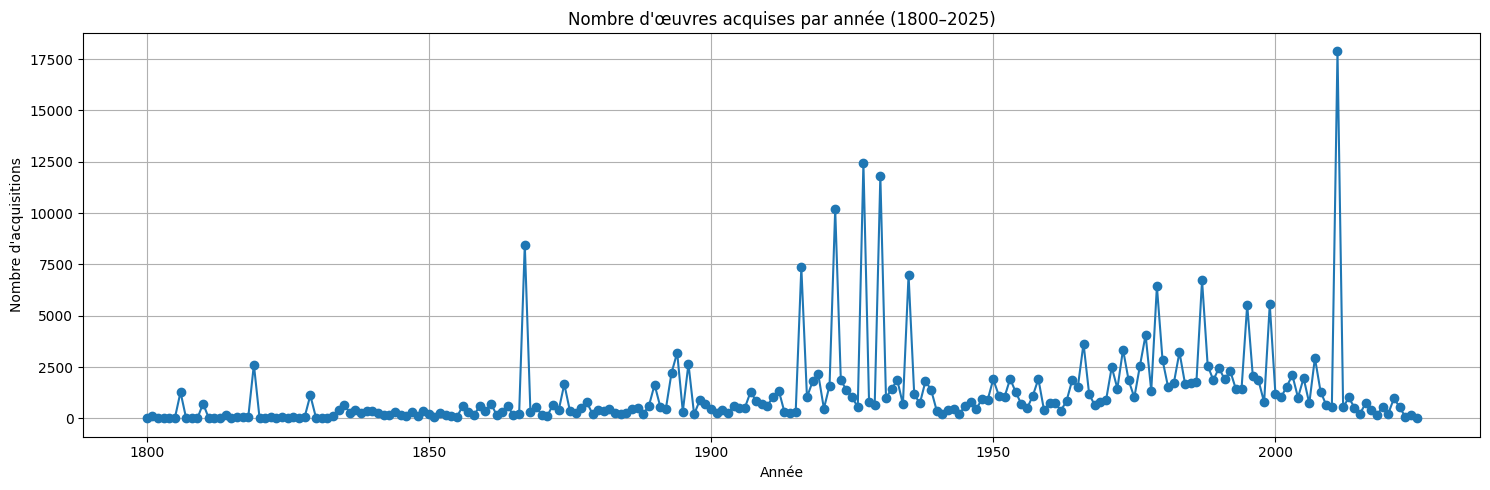

In [48]:
# Première visualisation : nombre d'œuvres acquises par année (1800–2025)

# Série : nombre d'acquisitions par année
acquisitions_par_annee = (
    df_clean["Annee_acquisition"]
    .value_counts()
    .sort_index()
)

# Filtre sur la période 1800–2025
serie_annee_plot = acquisitions_par_annee[
    (acquisitions_par_annee.index >= 1800) &
    (acquisitions_par_annee.index <= 2025)
]

plt.figure(figsize=(15, 5))
plt.plot(serie_annee_plot.index, serie_annee_plot.values, marker='o', linestyle='-')
plt.title("Nombre d'œuvres acquises par année (1800–2025)")
plt.xlabel("Année")
plt.ylabel("Nombre d'acquisitions")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Ce n'est pas idéal comme visulaisation, 
# les valeurs par années sont "collées" à l'axe des x,
# en revanche ça permets d'isoler/inspecter les valeurs trop elevées


In [49]:
#Inspection des valeurs elevées 
moyenne = acquisitions_par_annee_filtrées.mean()
ecart_type = acquisitions_par_annee_filtrées.std()

# Pic = 2 écarts-types au-dessus de la moyenne
seuil = moyenne + 2 * ecart_type

pics = acquisitions_par_annee_filtrées[acquisitions_par_annee_filtrées > seuil]

print("Moyenne :", moyenne)
print("Pics :")
print(pics)


Moyenne : 1219.4690265486727
Pics :
1867     8468
1916     7353
1922    10194
1927    12433
1930    11798
1935     6993
1979     6439
1987     6733
1995     5537
1999     5553
2011    17884
Name: count, dtype: int64


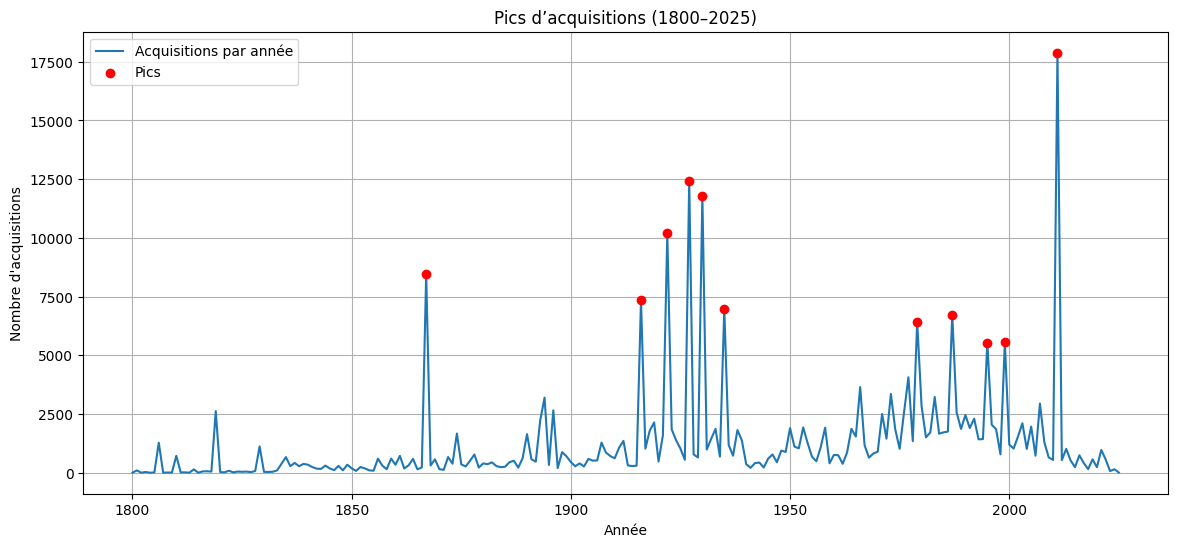

In [50]:
#Representation visuelle 

plt.figure(figsize=(14, 6))
plt.plot(serie_annee_plot.index, serie_annee_plot.values, label="Acquisitions par année")
plt.scatter(pics.index, pics.values, color='red', label="Pics", zorder=5)
plt.xlabel("Année")
plt.ylabel("Nombre d'acquisitions")
plt.title("Pics d’acquisitions (1800–2025)")
plt.legend()
plt.grid(True)
plt.show()

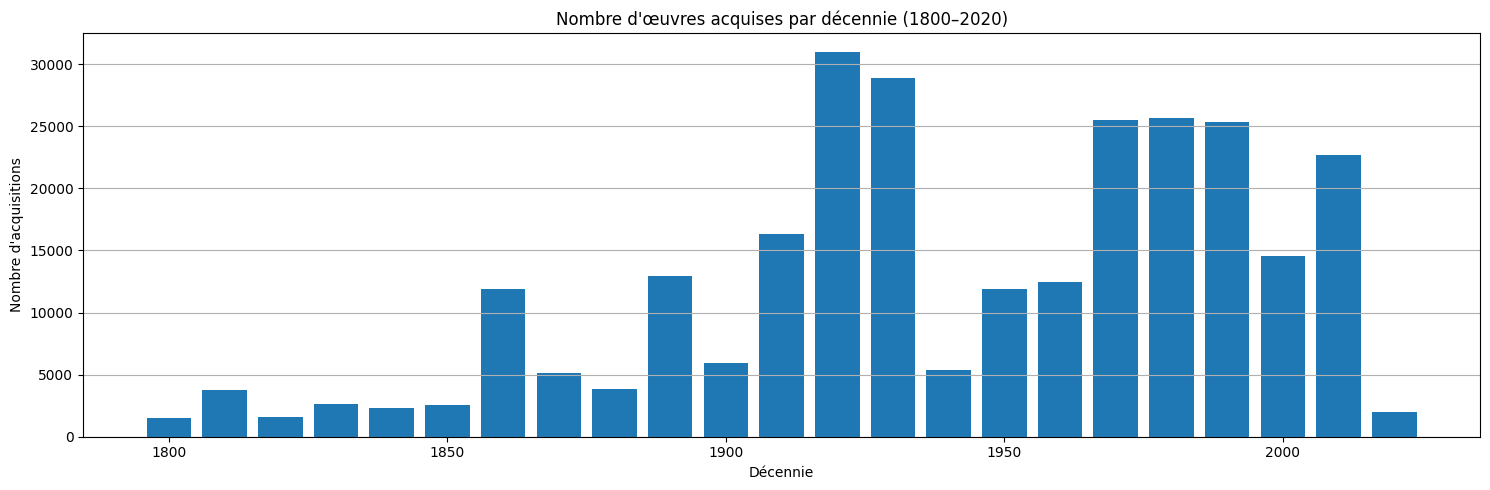

In [51]:
#Represenattion visuelle des acquisitions apr decennie 
serie_decennie_plot = acquisitions_par_decennie_filtrées.fillna(0)

plt.figure(figsize=(15, 5))
plt.bar(serie_decennie_plot.index.astype(int), serie_decennie_plot.values, width=8)
plt.title("Nombre d'œuvres acquises par décennie (1800–2020)")
plt.xlabel("Décennie")
plt.ylabel("Nombre d'acquisitions")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [64]:
#la visualistaion par decennie est, à priori, cohérente
# années 20/30/40 (pic : "années folles": effervessence artistique et sociale, puis fin des 30 glorieuses avec un pic années 60/70 )



#  APPRECIATION DE LA REPARTITION SPATIALE/GEOGRAPHIQUE DES ACQUISITIONS 

In [52]:
# Calculer le nombre d'acquisitions par région
acquisitions_par_region = df_clean["Region"].value_counts().sort_values(ascending=False)

# Afficher le résultat
print(acquisitions_par_region)

# Ajouter une colonne "Total_acquisitions_region"
df_clean["Total_acquisitions_region"] = df_clean["Region"].map(acquisitions_par_region)


Region
Ile-de-France                 131318
Grand Est                      28171
Hauts-de-France                25762
Bourgogne-Franche-Comté        25082
Provence-Alpes-Côte d'Azur     24441
Occitanie                      16298
Pays-de-la-Loire               13683
Nouvelle-Aquitaine             13568
Auvergne-Rhône-Alpes            8764
Normandie                       7987
Bretagne                        7548
Centre-Val de Loire             6606
DROM                             130
Corse                             22
Name: count, dtype: int64


In [53]:


# Nombre d'acquisitions par région à partir de df_clean
acq_region = df_clean["Region"].value_counts().reset_index()
acq_region.columns = ["Region", "Total_acquisitions_region"]

# Trier pour avoir les plus petites en bas du graphique (barres horizontales)
acq_region = acq_region.sort_values("Total_acquisitions_region", ascending=True)

# Nom exact de l’Île-de-France dans tes données
idf_label = "Île-de-France" if (acq_region["Region"] == "Île-de-France").any() else "Ile-de-France"

# Couleurs : Île-de-France en rouge, le reste en gris
colors = ["crimson" if r == idf_label else "lightgray" for r in acq_region["Region"]]

# Barres horizontales
fig = px.bar(
    acq_region,
    x="Total_acquisitions_region",
    y="Region",
    orientation="h"
)

fig.update_traces(marker_color=colors)

fig.update_layout(
    title="Répartition des acquisitions par région" ,
    xaxis_title="Nombre d'acquisitions",
    yaxis_title="Région",
)

fig.show()


In [ ]:
# La représentation des acquisitions par région met en lumière une disparité extrême
# entre l'Île-de-France et le reste du territoire.
# Cette concentration confirme le phénomène de centralisation souvent dénoncé
# par les sociologues, anthropologues et historiens comme un facteur d'aggravation
# des inégalités entre les territoires.
# Dans l'étape suivante, on s'intéressera à l'évolution de ce phénomène dans le temps,


In [54]:
# Combiner année et région 
# 1) Nombre d'acquisitions par région ET par année d'acquisition
acq_region_year = (
    df_clean.groupby(["Region", "Annee_acquisition"])
            .size()
            .reset_index(name="Nb_acquisitions")
)

# S'assurer que l'année est bien un entier
acq_region_year["Annee_acquisition"] = acq_region_year["Annee_acquisition"].astype(int)

# 2) Tableau croisé (pour contrôle)
table_region_year = (
    acq_region_year
        .pivot(index="Region", columns="Annee_acquisition", values="Nb_acquisitions")
        .fillna(0)
        .astype(int)
)

pd.set_option("display.max_columns", 50)
print(table_region_year)

print("Années min/max :", table_region_year.columns.min(), table_region_year.columns.max())


Annee_acquisition           1793  1794  1795  1796  1797  1798  1799  1800  \
Region                                                                       
Auvergne-Rhône-Alpes           0     1     0     0     1     0    70     1   
Bourgogne-Franche-Comté        2     0     0     0     0     0   130     0   
Bretagne                       0   103     0     0     0     0     0     0   
Centre-Val de Loire           11    25     0     0     0     0     0     0   
Corse                          0     0     0     0     0     0     0     0   
DROM                           0     0     0     0     0     0     0     0   
Grand Est                      6     0     1     0     0     0     2     0   
Hauts-de-France                2     0     1     0     0     0     0     0   
Ile-de-France               3250   137    97  1285    15     5    10     4   
Normandie                      4     1     0     0     0     0     0     0   
Nouvelle-Aquitaine             3     2     0     0     0     1  

In [55]:

# 1) Total France par année
total_par_an = (
    df_clean.groupby("Annee_acquisition")
            .size()
            .reset_index(name="Total_france")
)

# 2) Île-de-France par année
idf_par_an = (
    df_clean[df_clean["Region"] == "Ile-de-France"]   # change le libellé si besoin
            .groupby("Annee_acquisition")
            .size()
            .reset_index(name="Nb_IDF")
)

# 3) Fusion des deux
evo = total_par_an.merge(idf_par_an, on="Annee_acquisition", how="left")
evo["Nb_IDF"] = evo["Nb_IDF"].fillna(0)

# 4) Reste des régions
evo["Nb_autres"] = evo["Total_france"] - evo["Nb_IDF"]

# 5) Filtre temporel (19e siècle -> aujourd'hui)
evo_filtre = evo[(evo["Annee_acquisition"] >= 1800) &
                 (evo["Annee_acquisition"] <= 2025)]

# 6) Courbes IDF vs reste des régions
fig = px.line(
    evo_filtre,
    x="Annee_acquisition",
    y=["Nb_IDF", "Nb_autres"],
    title="Acquisitions : Île-de-France vs reste des régions (1800–2025)",
    labels={"Annee_acquisition": "Année", "value": "Nombre d'acquisitions"}
)

fig.update_layout(legend_title_text="")

fig.show()


In [70]:
#courbes qui comparent l'evolution des acquisions en IDF depuis 1950 vs reste du territoire
#visualisation peu concluante, valeur suscpicieuse pour 2011 car extremment elevée
#verifier si l'année 2011 est un outlier (erreur de saisie)

In [56]:
# Vérifier si certaines années (ex : 2011) sont atypiques en IDF
idf_par_an = (
    df_clean[df_clean["Region"] == "Ile-de-France"]
      .groupby("Annee_acquisition")
      .size()
      .reset_index(name="Nb_IDF")
      .sort_values("Nb_IDF", ascending=False)
)

print(idf_par_an.head(10))


     Annee_acquisition  Nb_IDF
218             2011.0   17188
134             1927.0   11913
137             1930.0   11473
129             1922.0    9896
123             1916.0    6910
142             1935.0    6572
186             1979.0    4907
0               1793.0    3250
180             1973.0    2704
184             1977.0    2400


In [72]:
# plusieurs années sont du même ordre de grandeur → c’est peut-être un vrai phénomène.
# En revanche les valeurs les plus elevées correspondent au debut de siècle 20/30 -> anachronisme , difficle de conclure 

In [57]:


# 1) Créer une colonne avec 2 catégories : Ile-de-France / Autres régions
df_clean["Categorie_region"] = np.where(
    df_clean["Region"] == "Ile-de-France",
    "Ile-de-France",
    "Autres régions"
)

# 2) Nombre d'acquisitions par année ET par catégorie
camembert = (
    df_clean
    .groupby(["Annee_acquisition", "Categorie_region"])
    .size()
    .reset_index(name="Nb_acquisitions")
)

# 3) Option : ne garder que les années récentes (par ex. 1950+)
camembert_recent = camembert[camembert["Annee_acquisition"] >= 1950]

# 4) Graphique animé : 2 barres qui évoluent dans le temps
fig = px.bar(
    camembert_recent,
    x="Categorie_region",          # 2 barres : IDF / Autres
    y="Nb_acquisitions",           # hauteur = nb d'acquisitions
    color="Categorie_region",
    animation_frame="Annee_acquisition",   # 1 "image" par année
    title="Évolution des acquisitions : Île-de-France vs reste des régions (1950–…)"
)

fig.update_layout(
    xaxis_title="Catégorie de région",
    yaxis_title="Nombre d'acquisitions",
    legend_title=""
)

fig.show()


In [ ]:
# Phenomène de centralisation est en baisse depuis la moitié des années 90

# EVALUATION DE L'IMPACT DES CATEGORIES SUR L'EVOLUTION DES ACQUISITIONS 

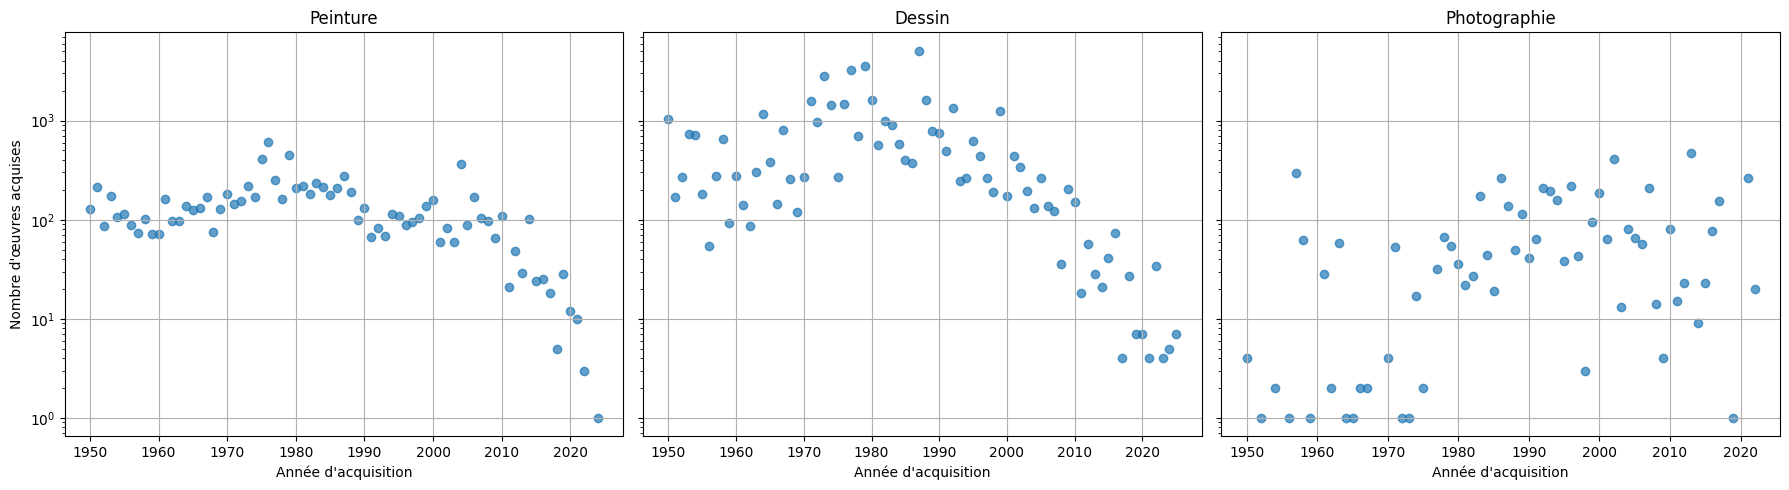

In [63]:
dom_cibles = ["peinture", "dessin", "photographie"]

df_3 = (
    df_clean[
        (df_clean["Annee_acquisition"] >= 1950) &
        (df_clean["Domaine"].isin(dom_cibles))
    ]
    .groupby(["Annee_acquisition", "Domaine"])
    .size()
    .reset_index(name="Nombre_oeuvres")
)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, domaine in zip(axes, dom_cibles):
    data = df_3[df_3["Domaine"] == domaine]
    ax.scatter(
        data["Annee_acquisition"],
        data["Nombre_oeuvres"],
        alpha=0.7
    )
    ax.set_title(domaine.capitalize())
    ax.set_xlabel("Année d'acquisition")
    ax.grid(True)

axes[0].set_ylabel("Nombre d'œuvres acquises")
for ax in axes:
    ax.set_yscale("log")

plt.tight_layout()
plt.show()


## Text minning

[('dotation', 80), ('fiscalité', 80), ('fiscalite', 80), ('fiscale', 62), ('fiscal', 61), ('dotations', 60), ('musée', 27), ('œuvre', 20), ('œuvres', 18), ('acquisition', 15), ('aussi', 12), ('artistes', 11), ('background', 11), ('musées', 10), ('grow', 10), ('orsay', 9), ('acquisitions', 8), ('art', 8), ('nos', 7), ('faire', 7)]


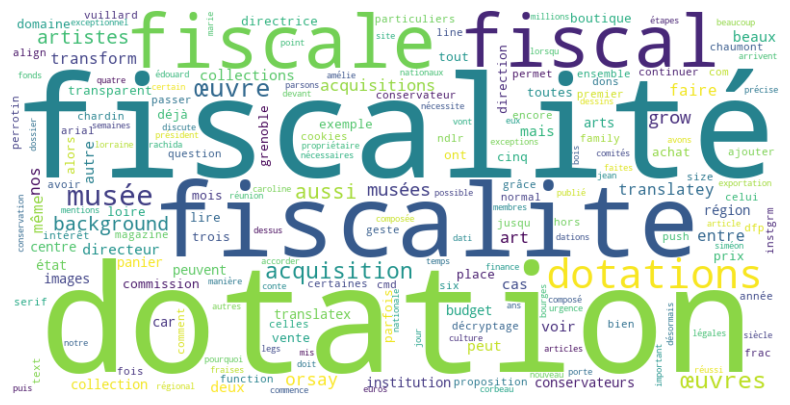

In [64]:
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Lire le texte
with open("article.txt", encoding="utf-8") as f:
    text = f.read()

# 2. Minuscule
text = text.lower()

# 3. Nettoyage
text = re.sub(r"[^a-zàâçéèêëîïôûùüÿçœæ\s]", " ", text)

# 4. Stopwords français
stop_fr = {
    "de","la","le","les","des","du","un","une","et","en","à","au","aux",
    "d","que","qui","quoi","dont","où","ne","pas","plus","pour","dans",
    "sur","par","avec","sans","ce","cet","cette","ces","se","sa","son",
    "ses","leur","leurs","est","sont","été","être","ou","on","nous",
    "vous","ils","elles","il","elle","y","a","aujourd","hui","comme"
}

# 5. Mots techniques du site à enlever (CSS/HTML etc.)
junk = {
    "style","width","height","border","padding","margin","display","flex",
    "color","font","center","left","right","top","bottom","radius",
    "solid","div","utm","googletag","instagram","embed","data"
}

# 6. Tokenisation + filtres
words = text.split()
words = [w for w in words
         if w not in stop_fr
         and w not in junk
         and len(w) > 2]

# 7. Fréquences
freq = Counter(words)

# 8. Sur-pondérer / forcer certains mots
cibles = {
    "dotation": 80,
    "dotations": 60,
    "fiscalité": 80,
    "fiscalite": 80,
    "fiscale": 60,
    "fiscal": 60
}
for mot, poids in cibles.items():
    freq[mot] = freq.get(mot, 0) + poids

print(freq.most_common(20))  # pour vérifier

# 9. Nuage de mots
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200,
    collocations=False
).generate_from_frequencies(freq)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [20]:
df_clean.to_csv("df_clean.csv", index=False)
